In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8b7e79e94f0764dad0a6d977f09715d01b2cef6d38c005883184996670d8509b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-03-21 07:46:15--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-03-21 07:46:15--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import cv2

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [11]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [13]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [14]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [15]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [17]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [18]:
train_dir = './train/NCT-CRC-HE-100K'

In [79]:
def elastic_transform(image, alpha, sigma):
    """탄성 변형 적용"""

    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = np.array(image)

    shape = image_np.shape[:2]

    ksize = 2 * int(sigma) + 1

    dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (ksize, ksize), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    indices = np.stack((y + dy, x + dx), axis=-1).astype(np.float32)
    distorted_image = cv2.remap(image_np, indices, None, cv2.INTER_LINEAR)

    return distorted_image

In [80]:
# transform = transforms.Compose([
#     # 크기 조정
#     transforms.Resize((224, 224)),

#     # 탄성 변형
#     transforms.Lambda(lambda x: elastic_transform(x, alpha=10, sigma=4)),

#     # H&E 염색 강도 변형 보정
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

#     # 회전 및 반전
#     transforms.RandomRotation(degrees=90),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),

#     # 랜덤 크롭 및 확대/축소
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),

#     # 블러 및 노이즈 추가
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
#     transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),

#     # Cutout (랜덤 영역 삭제)
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),

#     # 텐서 변환
#     transforms.ToTensor(),
# ])

In [81]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: elastic_transform(x, alpha=10, sigma=4)),
    transforms.ToTensor(),
])

In [82]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [83]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [84]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [85]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


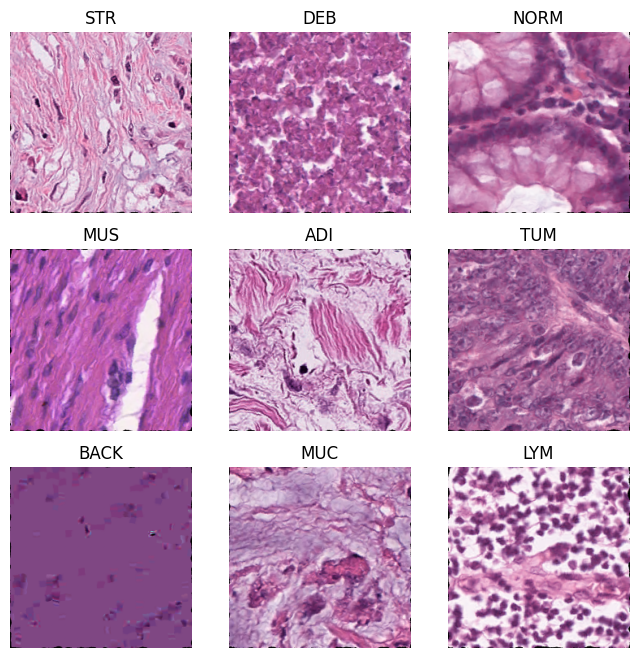

In [86]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [88]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [89]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [90]:
def evaluate(model, data_loader, criterion, device, epoch, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [91]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [92]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [05:53<00:00,  6.20it/s]


Train Loss: 0.6865, Train Accuracy: 75.48%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]


Validation Loss: 0.3950, Validation Accuracy: 86.15%
Balanced Accuracy: 0.8664

Epoch 2/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.3457, Train Accuracy: 87.87%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Validation Loss: 0.3385, Validation Accuracy: 88.43%
Balanced Accuracy: 0.8881

Epoch 3/30


Training: 100%|██████████| 2188/2188 [05:51<00:00,  6.23it/s]


Train Loss: 0.2361, Train Accuracy: 91.80%


Validation: 100%|██████████| 469/469 [01:03<00:00,  7.38it/s]


Validation Loss: 0.3824, Validation Accuracy: 86.51%
Balanced Accuracy: 0.8574

Epoch 4/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.1832, Train Accuracy: 93.80%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.2026, Validation Accuracy: 92.75%
Balanced Accuracy: 0.9301

Epoch 5/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.1464, Train Accuracy: 94.94%


Validation: 100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Validation Loss: 0.6137, Validation Accuracy: 81.47%
Balanced Accuracy: 0.8237

Epoch 6/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.1205, Train Accuracy: 95.88%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.50it/s]


Validation Loss: 0.3010, Validation Accuracy: 89.50%
Balanced Accuracy: 0.8939

Epoch 7/30


Training: 100%|██████████| 2188/2188 [05:51<00:00,  6.23it/s]


Train Loss: 0.0908, Train Accuracy: 96.92%


Validation: 100%|██████████| 469/469 [01:03<00:00,  7.43it/s]


Validation Loss: 0.0817, Validation Accuracy: 97.20%
Balanced Accuracy: 0.9719

Epoch 8/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.0738, Train Accuracy: 97.44%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Validation Loss: 0.1708, Validation Accuracy: 94.49%
Balanced Accuracy: 0.9490

Epoch 9/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0610, Train Accuracy: 97.89%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Validation Loss: 0.1426, Validation Accuracy: 95.23%
Balanced Accuracy: 0.9487

Epoch 10/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.0508, Train Accuracy: 98.21%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Validation Loss: 0.3753, Validation Accuracy: 89.67%
Balanced Accuracy: 0.9033

Epoch 11/30


Training: 100%|██████████| 2188/2188 [05:51<00:00,  6.23it/s]


Train Loss: 0.0431, Train Accuracy: 98.55%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]


Validation Loss: 1.6045, Validation Accuracy: 69.73%
Balanced Accuracy: 0.6655

Epoch 12/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.27it/s]


Train Loss: 0.0383, Train Accuracy: 98.68%


Validation: 100%|██████████| 469/469 [01:01<00:00,  7.57it/s]


Validation Loss: 0.1526, Validation Accuracy: 95.28%
Balanced Accuracy: 0.9520

Epoch 13/30


Training: 100%|██████████| 2188/2188 [05:51<00:00,  6.22it/s]


Train Loss: 0.0316, Train Accuracy: 98.90%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.51it/s]


Validation Loss: 0.1068, Validation Accuracy: 96.57%
Balanced Accuracy: 0.9648

Epoch 14/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.25it/s]


Train Loss: 0.0295, Train Accuracy: 98.95%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Validation Loss: 0.0810, Validation Accuracy: 97.55%
Balanced Accuracy: 0.9771

Epoch 15/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.25it/s]


Train Loss: 0.0234, Train Accuracy: 99.21%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.51it/s]


Validation Loss: 0.4433, Validation Accuracy: 89.89%
Balanced Accuracy: 0.8861

Epoch 16/30


Training: 100%|██████████| 2188/2188 [05:48<00:00,  6.28it/s]


Train Loss: 0.0249, Train Accuracy: 99.15%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.1323, Validation Accuracy: 96.00%
Balanced Accuracy: 0.9572

Epoch 17/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.27it/s]


Train Loss: 0.0192, Train Accuracy: 99.34%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Validation Loss: 0.1035, Validation Accuracy: 97.25%
Balanced Accuracy: 0.9696

Epoch 18/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.0213, Train Accuracy: 99.23%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.1564, Validation Accuracy: 95.71%
Balanced Accuracy: 0.9537

Epoch 19/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.25it/s]


Train Loss: 0.0176, Train Accuracy: 99.39%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Validation Loss: 0.2992, Validation Accuracy: 92.29%
Balanced Accuracy: 0.9166

Epoch 20/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0160, Train Accuracy: 99.45%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.51it/s]


Validation Loss: 0.0351, Validation Accuracy: 99.01%
Balanced Accuracy: 0.9896

Epoch 21/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0159, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]


Validation Loss: 0.0404, Validation Accuracy: 98.85%
Balanced Accuracy: 0.9885

Epoch 22/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.25it/s]


Train Loss: 0.0152, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.49it/s]


Validation Loss: 0.1355, Validation Accuracy: 96.45%
Balanced Accuracy: 0.9605

Epoch 23/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0133, Train Accuracy: 99.58%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.0466, Validation Accuracy: 98.58%
Balanced Accuracy: 0.9851

Epoch 24/30


Training: 100%|██████████| 2188/2188 [05:51<00:00,  6.23it/s]


Train Loss: 0.0136, Train Accuracy: 99.53%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Validation Loss: 0.0517, Validation Accuracy: 98.48%
Balanced Accuracy: 0.9839

Epoch 25/30


Training: 100%|██████████| 2188/2188 [05:48<00:00,  6.27it/s]


Train Loss: 0.0113, Train Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.0415, Validation Accuracy: 98.85%
Balanced Accuracy: 0.9879

Epoch 26/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0131, Train Accuracy: 99.55%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.47it/s]


Validation Loss: 0.0835, Validation Accuracy: 97.77%
Balanced Accuracy: 0.9761

Epoch 27/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.26it/s]


Train Loss: 0.0105, Train Accuracy: 99.65%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Validation Loss: 0.1445, Validation Accuracy: 96.43%
Balanced Accuracy: 0.9608

Epoch 28/30


Training: 100%|██████████| 2188/2188 [05:49<00:00,  6.25it/s]


Train Loss: 0.0098, Train Accuracy: 99.67%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.51it/s]


Validation Loss: 0.0325, Validation Accuracy: 99.05%
Balanced Accuracy: 0.9905

Epoch 29/30


Training: 100%|██████████| 2188/2188 [05:50<00:00,  6.24it/s]


Train Loss: 0.0104, Train Accuracy: 99.66%


Validation: 100%|██████████| 469/469 [01:03<00:00,  7.33it/s]


Validation Loss: 0.3651, Validation Accuracy: 92.98%
Balanced Accuracy: 0.9231

Epoch 30/30


Training: 100%|██████████| 2188/2188 [05:55<00:00,  6.16it/s]


Train Loss: 0.0091, Train Accuracy: 99.70%


Validation: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s]

Validation Loss: 0.0399, Validation Accuracy: 98.95%
Balanced Accuracy: 0.9891


In [93]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [01:02<00:00,  7.49it/s]

Test Loss: 0.0401, Test Accuracy: 98.83%
Balanced Accuracy: 0.9879


In [94]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


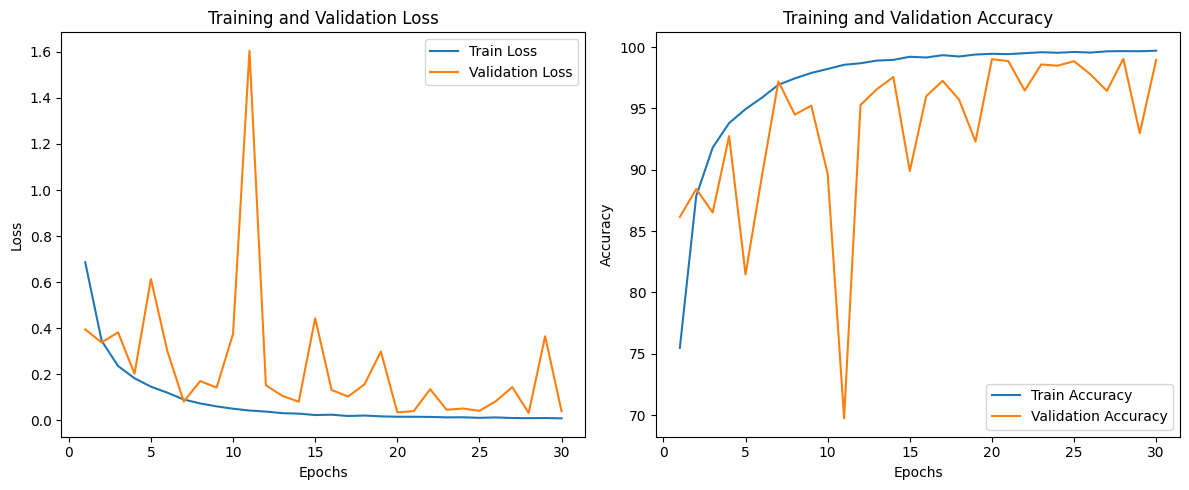

In [95]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 10.37 ms
Standard Deviation: 0.43 ms
Maximum Time: 13.25 ms
Minimum Time: 9.98 ms


In [97]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         9.03%       1.577ms        32.62%       5.694ms     118.625us       0.000us         0.00%       5.056ms     105.338us            48  
                                           aten::linear         1.07%     186.759us        17.42%       3.041ms      89.440us       0.000us         0.00%       3.628ms     106.696us            34  
         

In [98]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [99]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [100]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [01:03<00:00,  7.37it/s]


Test Loss: 0.0404, Test Accuracy: 98.79%
Overall - F1: 0.9876, Recall: 0.9874, Precision: 0.9879
Per-Class Metrics:
Class 0 - F1: 0.9965, Recall: 0.9942, Precision: 0.9987
Class 1 - F1: 0.9991, Recall: 0.9994, Precision: 0.9987
Class 2 - F1: 0.9817, Recall: 0.9925, Precision: 0.9711
Class 3 - F1: 0.9986, Recall: 0.9977, Precision: 0.9994
Class 4 - F1: 0.9837, Recall: 0.9753, Precision: 0.9924
Class 5 - F1: 0.9891, Recall: 0.9877, Precision: 0.9906
Class 6 - F1: 0.9852, Recall: 0.9840, Precision: 0.9863
Class 7 - F1: 0.9669, Recall: 0.9687, Precision: 0.9650
Class 8 - F1: 0.9881, Recall: 0.9874, Precision: 0.9888


<Figure size 2000x1200 with 0 Axes>

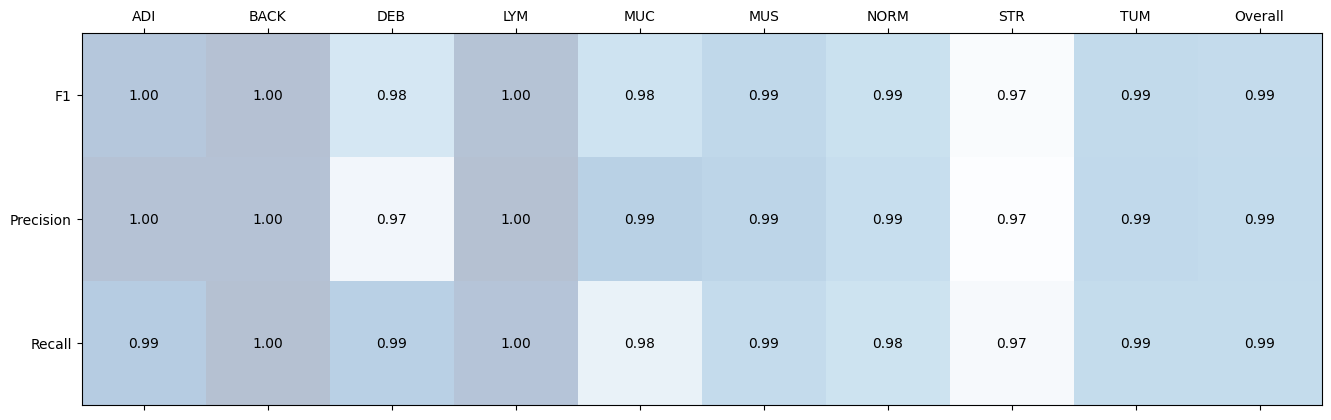

In [101]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [102]:
save_path = "HoViT_44_elasticAug.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_44_elasticAug.pth
